In [1]:
from google.colab import drive

drive.mount('/content/drive')

%cd /content/drive/MyDrive/ML_FInal_Project

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/ML_FInal_Project


In [2]:
# Walmart Sales Forecasting - Random Forest Experiment
# ================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings("ignore")

# Machine Learning Libraries
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import RobustScaler, LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score, TimeSeriesSplit
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.compose import ColumnTransformer

!pip install mlflow dagshub
# MLflow for experiment tracking
import mlflow
import mlflow.sklearn
from mlflow.tracking import MlflowClient




In [3]:
from pandas.api import types as ptypes

In [4]:
import dagshub
dagshub.init(repo_owner='lkata22', repo_name='walmart-sales-forecasting-final-project', mlflow=True)

mlflow.set_experiment("Model_EXperiment_Random_Forest")


Accessing as lkata22

Initialized MLflow to track repo "lkata22/walmart-sales-forecasting-final-project"

Repository lkata22/walmart-sales-forecasting-final-project initialized!

2025/07/08 16:39:13 INFO mlflow.tracking.fluent: Experiment with name 'Model_EXperiment_Random_Forest' does not exist. Creating a new experiment.


<Experiment: artifact_location='mlflow-artifacts:/740b926c20a44c55add4cf8532f8f6b6', creation_time=1751992753443, experiment_id='7', last_update_time=1751992753443, lifecycle_stage='active', name='Model_EXperiment_Random_Forest', tags={}>

Starting Walmart Sales Forecasting with Random Forest and MLflow...

1. Loading and preparing data...
Loaded datasets - Train: (421570, 5), Features: (8190, 12), Stores: (45, 3)
Merged dataset shape: (421570, 16)
Date range: 2010-02-05 00:00:00 to 2012-10-26 00:00:00

2. Creating features...
Features created. Dataset shape: (420212, 40)

3. Preparing model data...
Model features: 38
Final dataset shape: X=(420212, 38), y=(420212,)

4. Training model...
Training set: (336169, 38), Test set: (84043, 38)
Training with default parameters...

Model Performance:
Train - MAE: 759.42, RMSE: 1472.92, R²: 0.9961
Test  - MAE: 863.84, RMSE: 2688.98, R²: 0.9801

5. Plotting results...


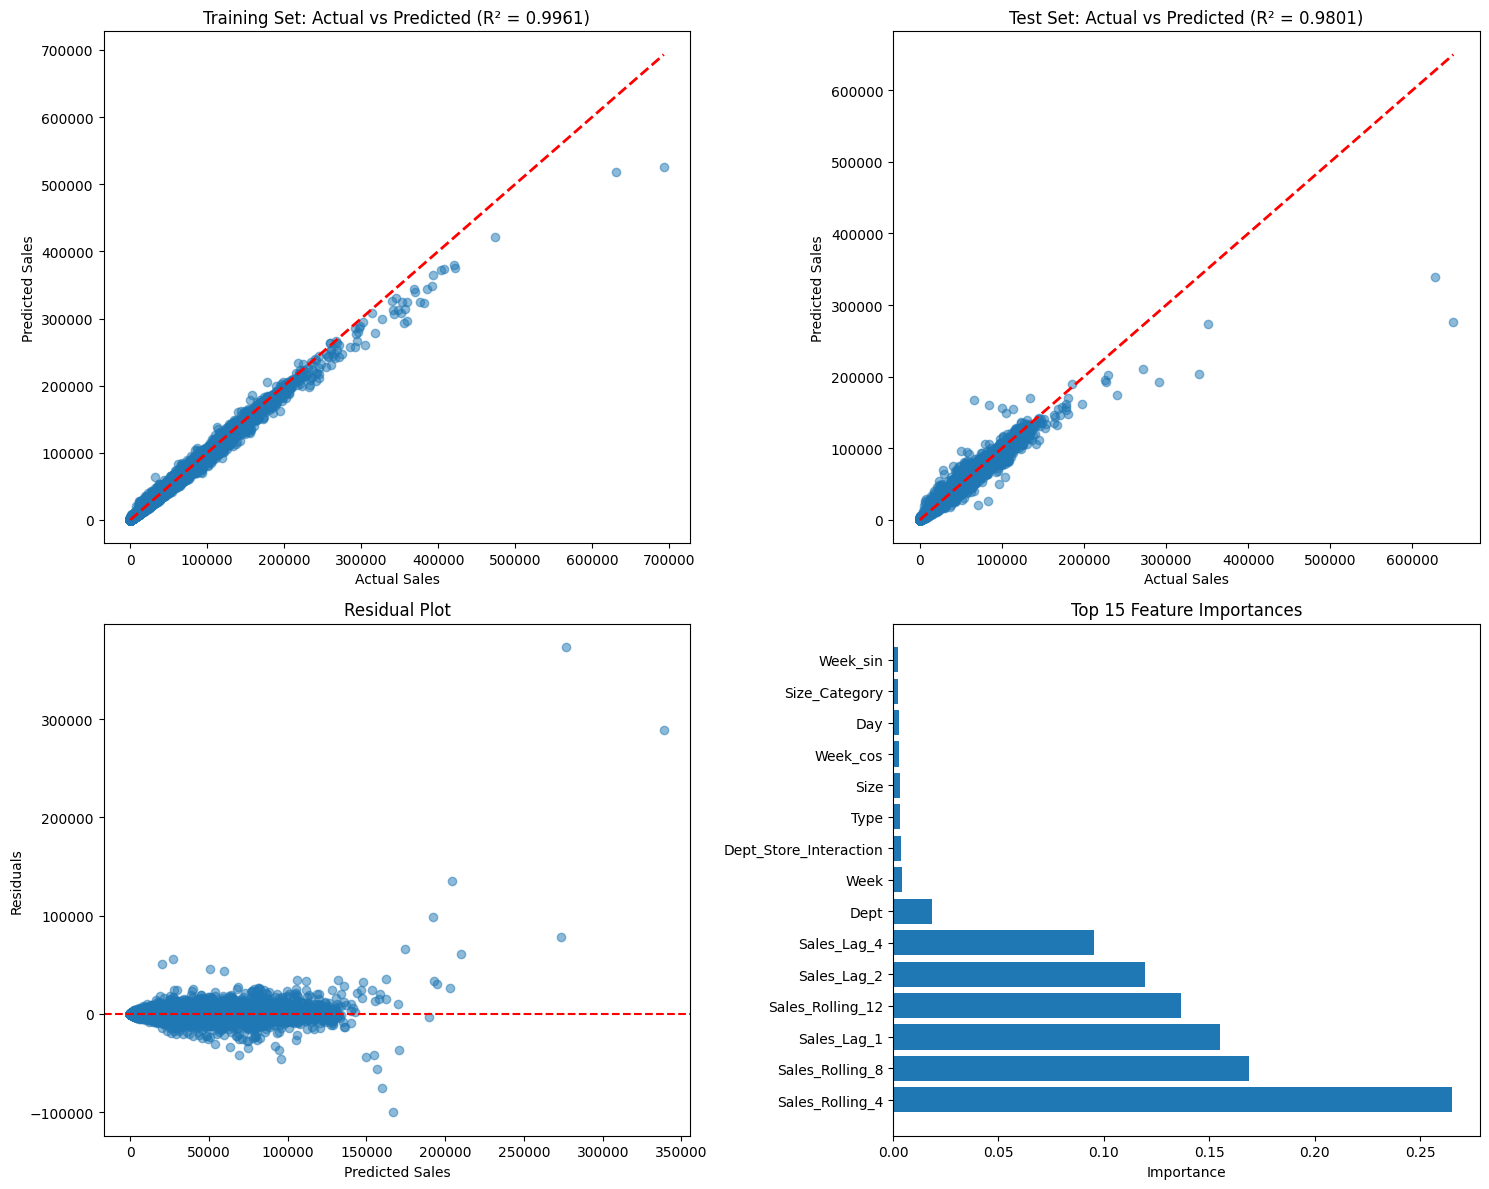


6. Generating forecast...
Last date in dataset: 2012-10-26 00:00:00
Generated 5 future dates
Features created. Dataset shape: (16615, 39)
Model features: 38
Final dataset shape: X=(16615, 38)
Generated forecast for 16615 store-department combinations

Forecast Summary:
        Date  Predicted_Sales
0 2012-11-02     4.827204e+07
1 2012-11-09     4.838053e+07
2 2012-11-16     4.783109e+07
3 2012-11-23     4.929789e+07
4 2012-11-30     4.809591e+07
🏃 View run walmart_rf_experiment at: https://dagshub.com/lkata22/walmart-sales-forecasting-final-project.mlflow/#/experiments/7/runs/75a59946e4b94f349ea56c9503a177b0
🧪 View experiment at: https://dagshub.com/lkata22/walmart-sales-forecasting-final-project.mlflow/#/experiments/7


In [9]:
# Walmart Sales Forecasting - Random Forest Model with MLflow Logging
# ====================================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder
import warnings
warnings.filterwarnings("ignore")

# MLflow imports
import mlflow
import mlflow.sklearn
from mlflow.tracking import MlflowClient
import pickle
import os

# Set random seed for reproducibility
np.random.seed(42)

class WalmartSalesForecaster:
    """Random Forest model for Walmart sales forecasting with MLflow logging"""

    def __init__(self, experiment_name="walmart_sales_forecasting"):
        self.model = None
        self.label_encoders = {}
        self.feature_importance = None
        self.train_mae = None
        self.train_rmse = None
        self.train_r2 = None
        self.experiment_name = experiment_name
        self._logged_params = set()

    def log_param_once(self, key, value):
        if key not in self._logged_params:
            mlflow.log_param(key, value)
            self._logged_params.add(key)


    def load_and_prepare_data(self, data_path="data"):
        """Load and prepare the dataset"""
        try:
            # Load datasets
            train_df = pd.read_csv(f"{data_path}/train.csv")
            features_df = pd.read_csv(f"{data_path}/features.csv")
            stores_df = pd.read_csv(f"{data_path}/stores.csv")

            print(f"Loaded datasets - Train: {train_df.shape}, Features: {features_df.shape}, Stores: {stores_df.shape}")

            # Log dataset info
            self.log_param_once("train_shape", train_df.shape)
            self.log_param_once("features_shape", features_df.shape)
            self.log_param_once("stores_shape", stores_df.shape)

            # Merge datasets
            df = train_df.merge(features_df, on=['Store', 'Date'], how='inner')
            df = df.merge(stores_df, on=['Store'], how='inner')

            # Handle duplicate IsHoliday columns
            if 'IsHoliday_y' in df.columns:
                df.drop(['IsHoliday_y'], axis=1, inplace=True)
                df.rename(columns={'IsHoliday_x': 'IsHoliday'}, inplace=True)

            # Convert date to datetime
            df['Date'] = pd.to_datetime(df['Date'], errors='coerce')

            # Remove rows with invalid dates
            df = df.dropna(subset=['Date'])

            # Log data info
            self.log_param_once("merged_shape", df.shape)
            self.log_param_once("date_range_start", str(df['Date'].min()))
            self.log_param_once("date_range_end", str(df['Date'].max()))
            self.log_param_once("unique_stores", df['Store'].nunique())
            self.log_param_once("unique_departments", df['Dept'].nunique())

            print(f"Merged dataset shape: {df.shape}")
            print(f"Date range: {df['Date'].min()} to {df['Date'].max()}")

            return df

        except Exception as e:
            print(f"Error loading data: {e}")
            self.log_param_once("data_loading_error", str(e))
            raise

    def create_features(self, df):
        """Create features for the model"""
        df = df.copy()

        # Log feature creation start
        self.log_param_once("feature_creation_start", True)

        # Detect whether we have sales in this DataFrame
        has_sales = 'Weekly_Sales' in df.columns
        self.log_param_once("has_sales_in_data", has_sales)

        # Filter out non-positive sales only if we have sales
        if has_sales:
            original_rows = len(df)
            df = df[df['Weekly_Sales'] > 0]
            filtered_rows = len(df)
            self.log_param_once("rows_filtered_negative_sales", original_rows - filtered_rows)

        # Time-based features
        df['Year'] = df['Date'].dt.year
        df['Month'] = df['Date'].dt.month
        df['Week'] = df['Date'].dt.isocalendar().week
        df['Day'] = df['Date'].dt.day
        df['DayOfWeek'] = df['Date'].dt.dayofweek
        df['Quarter'] = df['Date'].dt.quarter

        # Cyclical encodings
        df['Month_sin'] = np.sin(2 * np.pi * df['Month'] / 12)
        df['Month_cos'] = np.cos(2 * np.pi * df['Month'] / 12)
        df['Week_sin'] = np.sin(2 * np.pi * df['Week'] / 52)
        df['Week_cos'] = np.cos(2 * np.pi * df['Week'] / 52)

        # Holiday indicator
        df['IsHoliday'] = df['IsHoliday'].astype(int)

        # Size categories
        df['Size_Category'] = pd.cut(
            df['Size'],
            bins=[0, 50000, 100000, 150000, float('inf')],
            labels=['Small','Medium','Large','XLarge']
        )

        # Fill economic features
        economic_features = ['Temperature','Fuel_Price','CPI','Unemployment']
        for feat in economic_features:
            if feat in df.columns:
                median_val = df[feat].median()
                df[feat] = df[feat].fillna(median_val)
                self.log_param_once(f"{feat}_median_fill", median_val)

        # Markdown features
        markdowns = ['MarkDown1','MarkDown2','MarkDown3','MarkDown4','MarkDown5']
        for m in markdowns:
            if m in df.columns:
                df[m] = df[m].fillna(0)
                df[f'{m}_Flag'] = (df[m] > 0).astype(int)

        if any(m in df.columns for m in markdowns):
            md_cols = [m for m in markdowns if m in df.columns]
            df['Total_MarkDown'] = df[md_cols].sum(axis=1)
            self.log_param_once("markdown_features_created", len(md_cols))

        # Sort for grouping operations
        df = df.sort_values(['Store','Dept','Date']).reset_index(drop=True)

        # Lag & rolling features only if we have real sales
        if has_sales:
            # Lag features
            for lag in [1,2,4]:
                df[f'Sales_Lag_{lag}'] = (
                    df.groupby(['Store','Dept'])['Weekly_Sales'].shift(lag)
                )

            # Rolling features
            for w in [4,8,12]:
                df[f'Sales_Rolling_{w}'] = (
                    df.groupby(['Store','Dept'])['Weekly_Sales']
                      .transform(lambda x: x.rolling(window=w, min_periods=1).mean())
                )

            self.log_param_once("lag_features_created", 3)
            self.log_param_once("rolling_features_created", 3)

        # Department-Store interaction
        df['Dept_Store_Interaction'] = df['Dept'] * df['Store']

        # Log final feature info
        self.log_param_once("final_feature_count", len(df.columns))
        self.log_param_once("final_dataset_shape", df.shape)

        print(f"Features created. Dataset shape: {df.shape}")
        return df

    def prepare_model_data(self, df, is_training=True):
        """Prepare data for model training or forecasting"""
        # Select features for modeling
        feature_columns = [
            'Store', 'Dept', 'Size', 'Year', 'Month', 'Week', 'Day', 'DayOfWeek', 'Quarter',
            'Month_sin', 'Month_cos', 'Week_sin', 'Week_cos', 'IsHoliday',
            'Temperature', 'Fuel_Price', 'CPI', 'Unemployment',
            'MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5',
            'MarkDown1_Flag', 'MarkDown2_Flag', 'MarkDown3_Flag', 'MarkDown4_Flag', 'MarkDown5_Flag',
            'Total_MarkDown', 'Dept_Store_Interaction'
        ]

        # Add lag and rolling features
        if is_training:
            lag_features = [col for col in df.columns if 'Lag_' in col or 'Rolling_' in col]
            feature_columns.extend(lag_features)
        else:
            if hasattr(self, 'trained_features'):
                for feature in self.trained_features:
                    if 'Lag_' in feature or 'Rolling_' in feature:
                        if feature not in df.columns:
                            df[feature] = 0
                        feature_columns.append(feature)

        # Filter to available columns
        available_features = [col for col in feature_columns if col in df.columns]

        # Handle categorical features
        categorical_features = ['Type', 'Size_Category']
        for feature in categorical_features:
            if feature not in df.columns:
                continue

            if pd.api.types.is_numeric_dtype(df[feature]):
                available_features.append(feature)
            else:
                if feature not in self.label_encoders:
                    le = LabelEncoder()
                    df[feature] = le.fit_transform(df[feature].astype(str))
                    self.label_encoders[feature] = le
                else:
                    df[feature] = self.label_encoders[feature].transform(
                        df[feature].astype(str)
                    )
                available_features.append(feature)

        # Prepare final dataset
        X = df[available_features].fillna(0)

        # Store feature info
        if is_training:
            self.trained_features = available_features
            self.feature_medians = {}
            for feature in available_features:
                if 'Lag_' in feature or 'Rolling_' in feature:
                    self.feature_medians[feature] = X[feature].median()

            # Log feature info
            self.log_param_once("model_features", available_features)
            self.log_param_once("model_feature_count", len(available_features))
        else:
            for feature in self.trained_features:
                if feature not in X.columns:
                    default_val = self.feature_medians.get(feature, 0)
                    X[feature] = default_val
            X = X[self.trained_features]

        # Get target variable
        if is_training and 'Weekly_Sales' in df.columns:
            y = df['Weekly_Sales']
            # Log target statistics
            self.log_param_once("target_mean", y.mean())
            self.log_param_once("target_std", y.std())
            self.log_param_once("target_min", y.min())
            self.log_param_once("target_max", y.max())
        else:
            y = None

        print(f"Model features: {len(available_features)}")
        print(f"Final dataset shape: X={X.shape}", end="")
        if y is not None:
            print(f", y={y.shape}")
        else:
            print()

        return X, y, available_features

    def train_model(self, X, y, test_size=0.2, tune_hyperparameters=True):
        """Train the Random Forest model with MLflow logging"""

        # Log training parameters
        self.log_param_once("test_split_ratio", test_size) # Log test_size before splitting
        self.log_param_once("tune_hyperparameters", tune_hyperparameters)
        self.log_param_once("random_state", 42)

        # Split the data
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=test_size, random_state=42, shuffle=False
        )

        self.log_param_once("train_size", X_train.shape[0])
        self.log_param_once("test_size", X_test.shape[0]) # Log test_size after splitting

        print(f"Training set: {X_train.shape}, Test set: {X_test.shape}")

        if tune_hyperparameters:
            # Hyperparameter tuning
            param_grid = {
                'n_estimators': [100, 200],
                'max_depth': [10, 20, None],
                'min_samples_split': [2, 5],
                'min_samples_leaf': [1, 2],
                'max_features': ['sqrt', 'log2']
            }

            self.log_param_once("hyperparameter_grid", param_grid)

            print("Performing hyperparameter tuning...")
            rf = RandomForestRegressor(random_state=42, n_jobs=-1)
            grid_search = GridSearchCV(
                rf, param_grid, cv=3, scoring='neg_mean_absolute_error',
                n_jobs=-1, verbose=1
            )

            grid_search.fit(X_train, y_train)
            self.model = grid_search.best_estimator_

            # Log best parameters
            mlflow.log_params(grid_search.best_params_)
            self.log_param_once("best_cv_score", -grid_search.best_score_)

            print(f"Best parameters: {grid_search.best_params_}")
            print(f"Best CV score: {-grid_search.best_score_:.2f}")

        else:
            # Use default parameters
            default_params = {
                'n_estimators': 100,
                'max_depth': 20,
                'min_samples_split': 2,
                'min_samples_leaf': 1,
                'max_features': 'sqrt',
                'random_state': 42,
                'n_jobs': -1
            }

            self.model = RandomForestRegressor(**default_params)

            # Log default parameters
            mlflow.log_params(default_params)

            print("Training with default parameters...")
            self.model.fit(X_train, y_train)

        # Make predictions
        y_train_pred = self.model.predict(X_train)
        y_test_pred = self.model.predict(X_test)

        # Calculate metrics
        self.train_mae = mean_absolute_error(y_train, y_train_pred)
        self.train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
        self.train_r2 = r2_score(y_train, y_train_pred)

        test_mae = mean_absolute_error(y_test, y_test_pred)
        test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
        test_r2 = r2_score(y_test, y_test_pred)

        # Log metrics
        mlflow.log_metric("train_mae", self.train_mae)
        mlflow.log_metric("train_rmse", self.train_rmse)
        mlflow.log_metric("train_r2", self.train_r2)
        mlflow.log_metric("test_mae", test_mae)
        mlflow.log_metric("test_rmse", test_rmse)
        mlflow.log_metric("test_r2", test_r2)

        # Calculate overfitting metrics
        overfitting_mae = (test_mae - self.train_mae) / self.train_mae
        overfitting_rmse = (test_rmse - self.train_rmse) / self.train_rmse
        overfitting_r2 = self.train_r2 - test_r2

        mlflow.log_metric("overfitting_mae_ratio", overfitting_mae)
        mlflow.log_metric("overfitting_rmse_ratio", overfitting_rmse)
        mlflow.log_metric("overfitting_r2_diff", overfitting_r2)

        print(f"\nModel Performance:")
        print(f"Train - MAE: {self.train_mae:.2f}, RMSE: {self.train_rmse:.2f}, R²: {self.train_r2:.4f}")
        print(f"Test  - MAE: {test_mae:.2f}, RMSE: {test_rmse:.2f}, R²: {test_r2:.4f}")

        # Feature importance
        feature_names = X.columns
        self.feature_importance = pd.DataFrame({
            'feature': feature_names,
            'importance': self.model.feature_importances_
        }).sort_values('importance', ascending=False)

        # Log top features
        top_features = self.feature_importance.head(10)
        for i, row in top_features.iterrows():
            mlflow.log_metric(f"feature_importance_{row['feature']}", row['importance'])

        # Save feature importance as artifact
        importance_path = "feature_importance.csv"
        self.feature_importance.to_csv(importance_path, index=False)
        mlflow.log_artifact(importance_path)

        # Save label encoders
        encoders_path = "label_encoders.pkl"
        with open(encoders_path, 'wb') as f:
            pickle.dump(self.label_encoders, f)
        mlflow.log_artifact(encoders_path)

        return X_train, X_test, y_train, y_test, y_train_pred, y_test_pred

    def plot_results(self, X_train, X_test, y_train, y_test, y_train_pred, y_test_pred):
        """Plot model results and log to MLflow"""
        fig, axes = plt.subplots(2, 2, figsize=(15, 12))

        # 1. Actual vs Predicted (Train)
        axes[0,0].scatter(y_train, y_train_pred, alpha=0.5)
        axes[0,0].plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'r--', lw=2)
        axes[0,0].set_xlabel('Actual Sales')
        axes[0,0].set_ylabel('Predicted Sales')
        axes[0,0].set_title(f'Training Set: Actual vs Predicted (R² = {self.train_r2:.4f})')

        # 2. Actual vs Predicted (Test)
        test_r2 = r2_score(y_test, y_test_pred)
        axes[0,1].scatter(y_test, y_test_pred, alpha=0.5)
        axes[0,1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
        axes[0,1].set_xlabel('Actual Sales')
        axes[0,1].set_ylabel('Predicted Sales')
        axes[0,1].set_title(f'Test Set: Actual vs Predicted (R² = {test_r2:.4f})')

        # 3. Residuals
        residuals = y_test - y_test_pred
        axes[1,0].scatter(y_test_pred, residuals, alpha=0.5)
        axes[1,0].axhline(y=0, color='r', linestyle='--')
        axes[1,0].set_xlabel('Predicted Sales')
        axes[1,0].set_ylabel('Residuals')
        axes[1,0].set_title('Residual Plot')

        # 4. Feature Importance
        top_features = self.feature_importance.head(15)
        axes[1,1].barh(range(len(top_features)), top_features['importance'])
        axes[1,1].set_yticks(range(len(top_features)))
        axes[1,1].set_yticklabels(top_features['feature'])
        axes[1,1].set_xlabel('Importance')
        axes[1,1].set_title('Top 15 Feature Importances')

        plt.tight_layout()

        # Save and log plot
        plot_path = "model_results.png"
        plt.savefig(plot_path, dpi=300, bbox_inches='tight')
        mlflow.log_artifact(plot_path)
        plt.show()

        # Log residual statistics
        mlflow.log_metric("residuals_mean", residuals.mean())
        mlflow.log_metric("residuals_std", residuals.std())
        mlflow.log_metric("residuals_min", residuals.min())
        mlflow.log_metric("residuals_max", residuals.max())

    def generate_forecast(self, df, forecast_weeks=10):
        """Generate forecast for future weeks"""
        if self.model is None:
            raise ValueError("Model not trained yet!")

        # Log forecast parameters
        self.log_param_once("forecast_weeks", forecast_weeks)

        # Get the last date in the dataset
        last_date = df['Date'].max()
        print(f"Last date in dataset: {last_date}")
        self.log_param_once("forecast_start_date", str(last_date))

        # Generate future dates
        future_dates = []
        current_date = last_date

        for i in range(1, forecast_weeks + 1):
            try:
                next_date = current_date + timedelta(days=7)
                future_dates.append(next_date)
                current_date = next_date
            except Exception as e:
                print(f"Error generating date for week {i}: {e}")
                break

        if not future_dates:
            print("Could not generate future dates")
            return None

        self.log_param_once("forecast_end_date", str(future_dates[-1]))

        print(f"Generated {len(future_dates)} future dates")

        # Create forecast dataset
        forecast_data = []
        store_dept_combinations = df[['Store', 'Dept']].drop_duplicates()

        # Calculate recent sales averages
        recent_sales = df.groupby(['Store', 'Dept'])['Weekly_Sales'].agg(['mean', 'median']).reset_index()
        recent_sales.columns = ['Store', 'Dept', 'avg_sales', 'median_sales']

        for _, row in store_dept_combinations.iterrows():
            store = row['Store']
            dept = row['Dept']

            store_info = df[df['Store'] == store].iloc[0]
            sales_info = recent_sales[(recent_sales['Store'] == store) &
                                     (recent_sales['Dept'] == dept)]

            if len(sales_info) > 0:
                avg_sales = sales_info['avg_sales'].iloc[0]
                median_sales = sales_info['median_sales'].iloc[0]
            else:
                avg_sales = df['Weekly_Sales'].mean()
                median_sales = df['Weekly_Sales'].median()

            for future_date in future_dates:
                forecast_row = {
                    'Store': store,
                    'Dept': dept,
                    'Date': future_date,
                    'Size': store_info['Size'],
                    'Type': store_info['Type'],
                    'IsHoliday': False,
                    'Temperature': df['Temperature'].mean(),
                    'Fuel_Price': df['Fuel_Price'].mean(),
                    'CPI': df['CPI'].mean(),
                    'Unemployment': df['Unemployment'].mean(),
                    'MarkDown1': 0,
                    'MarkDown2': 0,
                    'MarkDown3': 0,
                    'MarkDown4': 0,
                    'MarkDown5': 0,
                    'Sales_Lag_1': avg_sales,
                    'Sales_Lag_2': avg_sales,
                    'Sales_Lag_4': avg_sales,
                    'Sales_Rolling_4': avg_sales,
                    'Sales_Rolling_8': avg_sales,
                    'Sales_Rolling_12': avg_sales,
                }
                forecast_data.append(forecast_row)

        # Create forecast DataFrame
        forecast_df = pd.DataFrame(forecast_data)

        # Add time features
        forecast_df = self.create_features(forecast_df)

        # Prepare for prediction
        X_forecast, _, feature_names = self.prepare_model_data(forecast_df, is_training=False)

        # Make predictions
        forecast_predictions = self.model.predict(X_forecast)

        # Add predictions to forecast DataFrame
        forecast_df['Predicted_Sales'] = forecast_predictions

        # Log forecast statistics
        total_forecast = forecast_df.groupby('Date')['Predicted_Sales'].sum().reset_index()
        mlflow.log_metric("forecast_total_mean", total_forecast['Predicted_Sales'].mean())
        mlflow.log_metric("forecast_total_std", total_forecast['Predicted_Sales'].std())
        mlflow.log_metric("forecast_total_min", total_forecast['Predicted_Sales'].min())
        mlflow.log_metric("forecast_total_max", total_forecast['Predicted_Sales'].max())

        # Save forecast as artifact
        forecast_path = "forecast_results.csv"
        forecast_df[['Store', 'Dept', 'Date', 'Predicted_Sales']].to_csv(forecast_path, index=False)
        mlflow.log_artifact(forecast_path)

        # Save forecast summary
        summary_path = "forecast_summary.csv"
        total_forecast.to_csv(summary_path, index=False)
        mlflow.log_artifact(summary_path)

        print(f"Generated forecast for {len(forecast_df)} store-department combinations")

        return forecast_df[['Store', 'Dept', 'Date', 'Predicted_Sales']]

def main():
    """Main function to run the complete pipeline with MLflow logging"""

    # Start MLflow run
    with mlflow.start_run(run_name="walmart_rf_experiment"):

        print("Starting Walmart Sales Forecasting with Random Forest and MLflow...")

        # Log experiment metadata
        mlflow.log_param("model_type", "RandomForest")
        mlflow.log_param("task", "sales_forecasting")
        mlflow.log_param("dataset", "walmart_sales")
        mlflow.log_param("experiment_date", datetime.now().strftime("%Y-%m-%d %H:%M:%S"))

        # Initialize forecaster
        forecaster = WalmartSalesForecaster()

        # Load and prepare data
        print("\n1. Loading and preparing data...")
        df = forecaster.load_and_prepare_data()

        # Create features
        print("\n2. Creating features...")
        df_features = forecaster.create_features(df)

        # Prepare model data
        print("\n3. Preparing model data...")
        X, y, feature_names = forecaster.prepare_model_data(df_features, is_training=True)

        # Train model
        print("\n4. Training model...")
        results = forecaster.train_model(X, y, tune_hyperparameters=False)

        # Plot results
        print("\n5. Plotting results...")
        forecaster.plot_results(*results)

        # Generate forecast
        print("\n6. Generating forecast...")
        forecast = forecaster.generate_forecast(df_features, forecast_weeks=5)

        if forecast is not None:
            print("\nForecast Summary:")
            forecast_summary = forecast.groupby('Date')['Predicted_Sales'].sum().reset_index()
            print(forecast_summary)

            # Log final forecast summary
            mlflow.log_param("forecast_generated", True)
            mlflow.log_param("forecast_records", len(forecast))
        else:
            mlflow.log_param("forecast_generated", False)

        # Log run completion
        mlflow.log_param("run_completed", True)

        return forecaster

if __name__ == "__main__":
    best_model = main()